# Community detection in the Southern Women network via OtrisymNMF

This dataset documents the participation of 18 women in 14 social events held in a Southern town in the United States. The bipartite network is composed of 32 nodes, 18 for women and 14 for events. An edge exists between a woman and an event if the woman attended that event.

In [98]:
import networkx as nx # useful python package for networks and graphs
G = nx.davis_southern_women_graph() # Get the Southern Women network
# Recovery of the women and events from node's graph
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

## Selecting the value of r, the number of communities

We aim to use OtrisymNMF to detect communities within the network. Since the number of communities r is unknown, we need to select a reasonable value for it.

To do this, we rely on the elbow method. This technique involves plotting the reconstruction error as a function of r, and identifying the point where the error reduction starts to level off — known as the elbow of the curve. Beyond this point, increasing r no longer significantly improves the reconstruction.

This approach allows us to choose a value of r that captures the general structure of the network while avoiding overfitting by adding unnecessary complexity.



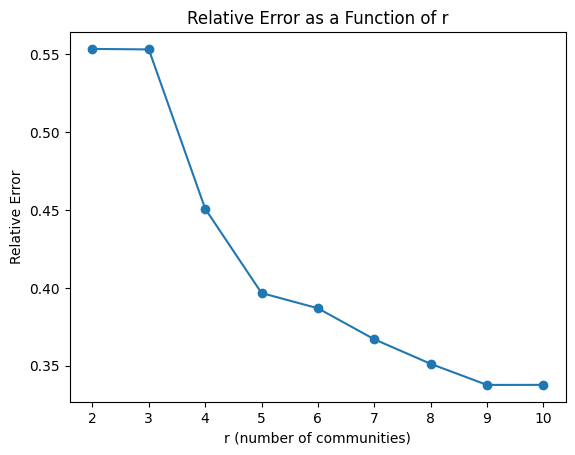

In [99]:
import OtrisymNMF
import matplotlib.pyplot as plt
X = nx.adjacency_matrix(G) # adjacency matrix of the graph
errors=[]
r_listes=range(2,11)
for r in r_listes : # compute the factorization for different values of r
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,r,numTrials=20,verbosity=0)
    errors.append(error)
# Plot of the relative reconstruction error as a function of r
plt.plot(r_listes,errors,marker='o')
plt.title('Relative Error as a Function of r')
plt.xlabel('r (number of communities)')
plt.ylabel('Relative Error')
plt.show()

We choose r = 5, since the reconstruction error does not decrease significantly after this value.
## Community detection via OtrisymNMF with the chosen value of r
We detect the communities using OtrisymNMF with the selected value of r. Our method gives :
- v is a vector of length n (with n being the number of nodes) indicating the community index for each node.
- w is a vector of length n indicating the  importance of a node within its community.
- S describes interactions between the r communities.


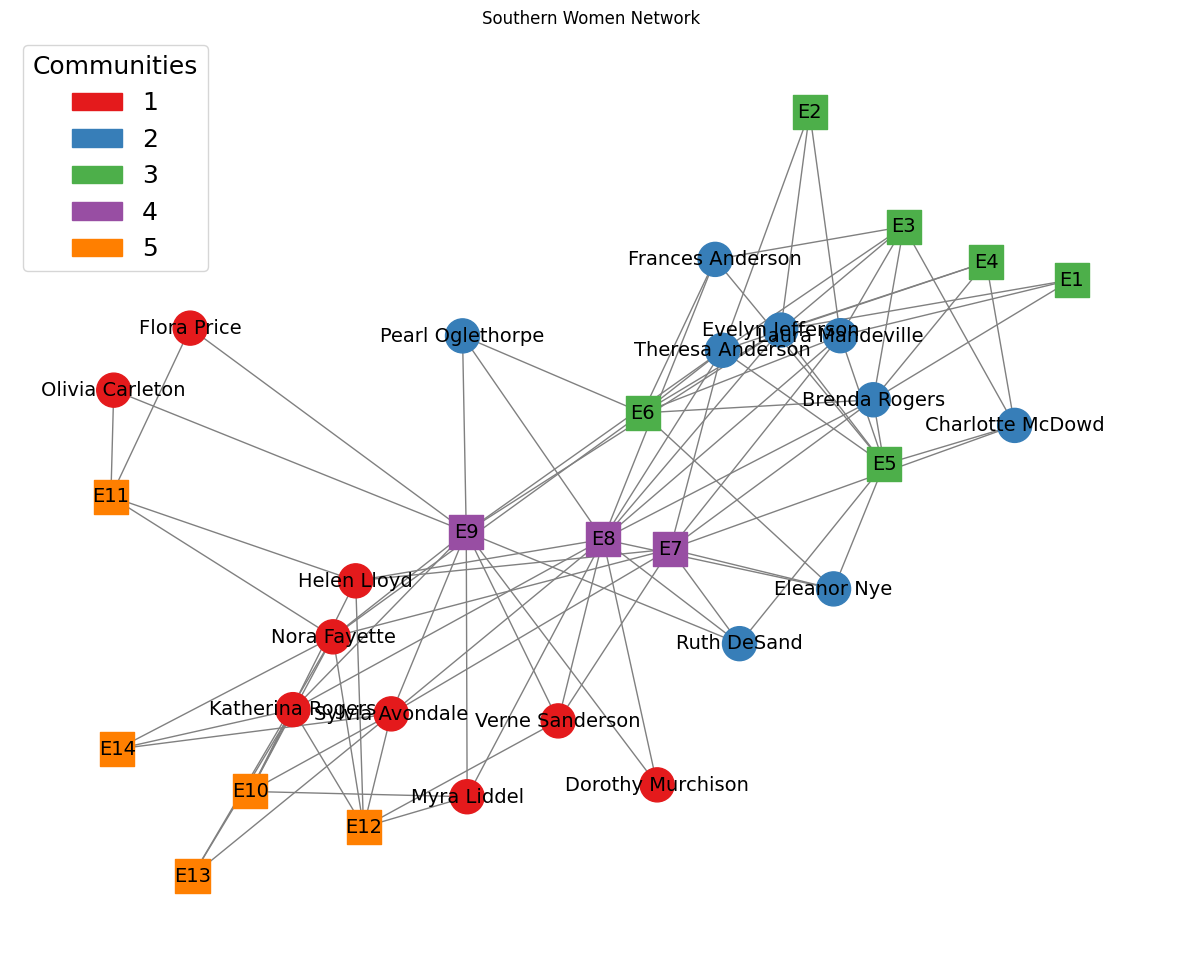

In [100]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import random

random.seed(45)
X = nx.adjacency_matrix(G) #adjacency matrix
w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,5,numTrials=10,verbosity=0)


# Graph Display with labels v
pos = nx.spring_layout(G, seed=12)

colors = ['#E41A1C',  # rouge vif
          '#377EB8',  # bleu soutenu
          '#4DAF4A',  # vert modéré
          '#984EA3',  # violet foncé
          '#FF7F00']  # orange vif


node_list = list(G.nodes())
node_colors = [colors[v[i]] for i in range(len(node_list))]
plt.figure(figsize=(15,12))

nx.draw_networkx_nodes(G, pos,
                       nodelist=women,
                       node_color=[node_colors[node_list.index(n)] for n in women],
                       node_shape='o',
                       node_size=600)

nx.draw_networkx_nodes(G, pos,
                       nodelist=events,
                       node_color=[node_colors[node_list.index(n)] for n in events],
                       node_shape='s',
                       node_size=600)


nx.draw_networkx_edges(G, pos, edge_color='gray')


nx.draw_networkx_labels(G, pos, font_size=14)
legend_patches = []
for i in range(5):  # 5 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i+1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='upper left', fontsize=18, title_fontsize=18, title="Communities")
plt.title("Southern Women Network")
plt.axis('off')
plt.show()

The five communities identified by OtrisymNMF in the Southern Women network, with women (circles) and events (squares) clearly separated, and each community represented by a distinct color

## Visualization of community interactions using the matrix S

Community: 1: ['Verne Sanderson', 'Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd', 'Dorothy Murchison', 'Olivia Carleton', 'Flora Price']
Community: 2: ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Frances Anderson', 'Eleanor Nye', 'Pearl Oglethorpe', 'Ruth DeSand']
Community: 3: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6']
Community: 4: ['E7', 'E8', 'E9']
Community: 5: ['E10', 'E11', 'E12', 'E13', 'E14']


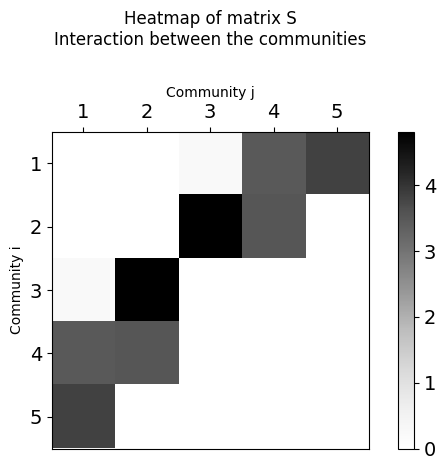

In [101]:
import numpy as np
# Print the communities
for i in range(max(v)+1):
    index=np.where(v == i)[0]
    print(f"Community: {i+1}: {[list(G.nodes())[j] for j in index] }")
# Display of S with a heatmap
plt.imshow(S, cmap='Greys')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
labels = np.arange(1, S.shape[0] + 1)
plt.xticks(fontsize=14,ticks=np.arange(S.shape[1]), labels=labels)
plt.yticks(fontsize=14,ticks=np.arange(S.shape[0]), labels=labels)
plt.title("Heatmap of matrix S\nInteraction between the communities", pad=30)
plt.xlabel('Community j')
plt.ylabel('Community i')
plt.tight_layout()
plt.show()

The matrix S provides a clearer interpretation of the community structure. The matrix S, clearly illustrating the bipartition and the interactions between communities.


## Community detection via DCBM (initialization SVCA)

In [104]:
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI

DCBM_partition=DC_BM(G,5,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=5,verbosity=1,tri=False,init_method="SVCA")
print(f" Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :{NMI(DCBM_partition,v)}")



Best logP : -735.3152336453757
 Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF  1.0000000000000002


The partition found by DCBM is the same as the one obtained by OtrisymNMF.

## Tests initialization by SVCA compared to random à supprimer

In [103]:
import OtrisymNMF
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI
import random
import numpy as np
partition_optimal=[3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,4,4,4,4,4]
random.seed(42)
nb_tests=100
trials=10
NMI_moyen={"OtrisymNMF_rdm":[],"OtrisymNMF_SVCA":[],"KL_EM_rdm":[],"KL_EM_SVCA":[]}
for test in range(nb_tests):

    # OtrsisymNMF rdm
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,5,numTrials=trials,verbosity=0,init_method="random")
    NMI_moyen["OtrisymNMF_rdm"].append(NMI(v,partition_optimal))

    # OtrisymNMF SVCA
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,5,numTrials=trials,verbosity=0,init_method="SVCA")
    NMI_moyen["OtrisymNMF_SVCA"].append(NMI(v,partition_optimal))

    # KL_EM rdm
    DCBM_partition=DC_BM(G,5,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="random")
    NMI_moyen["KL_EM_rdm"].append(NMI(DCBM_partition,partition_optimal))

    # KL_EM SVCA
    DCBM_partition=DC_BM(G,5,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="SVCA")
    NMI_moyen["KL_EM_SVCA"].append(NMI(DCBM_partition,partition_optimal))

for algo in ["OtrisymNMF_rdm","OtrisymNMF_SVCA","KL_EM_rdm","KL_EM_SVCA"]:
    print(f"NMI moyen pour {algo} : {np.mean(NMI_moyen[algo])} +- {np.std(NMI_moyen[algo])}")


NMI moyen pour OtrisymNMF_rdm : 0.9054564843026459 +- 0.08278334387528224
NMI moyen pour OtrisymNMF_SVCA : 0.9969991526894745 +- 0.021005931173678855
NMI moyen pour KL_EM_rdm : 1.0 +- 1.472877282518059e-16
NMI moyen pour KL_EM_SVCA : 1.0 +- 1.1957467920563633e-16
